### Рекламная и органическая позиции в поиске по артикулам для определенного бренда на ВБ в разрезе городов и запросов

__Цель:__ написать код, который будет отслеживать позиции в поиске ВБ в режиме реального времени (при запуске блокнота), в зависимости от городов, запроса, количества страниц и наличия рекламы, а также отслеживать рекламную ставку.

Данная работа с использованием блокнота поможет менеджеру бренда отслеживать, рекламную ставку, свои органические и рекламные позиции в поиске в целом, по городам и по запросам, заметить выпад из рекламы, из запроса или с первой страницы и своевременно принять меры.

Для исследования были выбраны:
- ниша - купальники для гимнастики
- бренд 'PROFI dance'
- города: Москва, Санкт-Петербург, Казань, Краснодар, Новосибирск, Екатеринбург (т.к. в этих городах расположены основные региональные склады ВБ для разных кластеров)

Данные о позициях были получены через открытое API площадки ВБ.

In [1]:
# Импортируем необходимые библиотеки
import requests
!pip install geopy
from geopy.geocoders import Nominatim
import datetime
import random
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Запрсы, по которым будем определять позиции в поиске
query_list=['купальник гимнастический', 'купальник для танцев', 'купальник для хореографии']
# Количество страниц, которые интересуют для просматривания позиций
max_page = 1 
# рассматриваемый бренд
brand='PROFI dance'

In [3]:
search_list=[]

In [4]:
# Города, по которым будем смотреть место в поиске
city_list=['Москва', 'Санкт-Петербург', 'Казань', 'Краснодар ', 'Новосибирск', 'Екатеринбург']

def generate_city_params(city):
    geolocator=Nominatim(user_agent="my_unique_app_name")
    location=geolocator.geocode(city)

    params = {
        'latitude': location.latitude,
        'longitude': location.longitude,
        'address': city
    }
    city_params= requests.get('https://user-geo-data.wildberries.ru/get-geo-info', params = params)
    return city_params

In [5]:
# получаем необходимые данные по открытому API ВБ и добавляем в список search_list
# цикл по заданным городам
for city in city_list:
    geo_info=generate_city_params(city)
# цикл по заданным запросам
    for query in query_list:
        cnt=0
# цикл по заданным страницам
        for page in range(1,max_page+1):
            res = requests.get(f'''https://search.wb.ru/exactmatch/ru/common/v18/search?ab_testing=false&curr=rub\
                                  &inheritFilters=false&lang=ru&page={page}&query={query}&resultset=catalog&sort=popular&spp=30&suppressSpellcheck=false&{geo_info.json()['xinfo']}''')
            products=res.json()['products']
# цикл по товарам заданного бренда
            for product in products:
                cnt+=1
                if product['brand'] == brand:
                    dt=datetime.datetime.now()
                    if product.get('log'):
                        search_list.append([
                              cnt,
                              product['id'],
                              product['name'],
                              product['log']['cpm'],
                              product['log']['position'],
                              product['log']['promoPosition'],
                              product['log']['tp'],
                              query,
                              dt,
                              city
                          ])
                    else:
                        search_list.append([
                              cnt,
                              product['id'],
                              product['name'],
                              0,
                              cnt,
                              -1,
                              '-',
                              query,
                              dt,
                              city
                          ])

In [6]:
# оформим результат в таблицу
import pandas as pd
df=pd.DataFrame(search_list)
df.columns=['position','id', 'name', 'cpm', 'position_org', 'promoPosition', 'tp', 'query', 'date','city']

In [7]:
# сгруппируем позиции в поиске по артикулу, запросу и городу
df_group=df.groupby(['id','query','city'])[['position', 'position_org', 'promoPosition','cpm']].mean().head(60)
display(df_group)
df_group=df_group.reset_index()

position  position_org  \
id        query                     city                                      
140021521 купальник гимнастический  Екатеринбург         15.0          65.0   
                                    Казань               14.0          59.0   
                                    Краснодар            15.0          59.0   
                                    Москва               15.0          59.0   
                                    Новосибирск          18.0          62.0   
                                    Санкт-Петербург      16.0          59.0   
          купальник для танцев      Екатеринбург          4.0          43.0   
                                    Казань                3.0          43.0   
                                    Краснодар             3.0          42.0   
                                    Москва                3.0          43.0   
                                    Новосибирск           6.0          46.0   
                                    Санкт-Петербург       4.0          43.0   
          купальник для хореографии Екатеринбург         10.0          42.0   
                                    Казань               10.0          39.0   
                                    Краснодар            10.0          39.0   
                                    Москва               10.0          39.0   
                                    Новосибирск          14.0          42.0   
                                    Санкт-Петербург      10.0          40.0   
150828479 купальник гимнастический  Екатеринбург         17.0          68.0   
                                    Казань               20.0          66.0   
                                    Краснодар            19.0          70.0   
                                    Москва               20.0          69.0   
                                    Новосибирск          13.0          60.0   
                                    Санкт-Петербург      21.0          70.0   
          купальник для танцев      Екатеринбург          7.0          46.0   
                                    Казань                8.0          46.0   
                                    Краснодар             8.0          46.0   
                                    Москва                8.0          46.0   
                                    Новосибирск           3.0          45.0   
                                    Санкт-Петербург      10.0          47.0   
          купальник для хореографии Екатеринбург         14.0          49.0   
                                    Казань               15.0          49.0   
                                    Краснодар            15.0          49.0   
                                    Москва               15.0          48.0   
                                    Новосибирск          13.0          42.0   
                                    Санкт-Петербург      15.0          51.0   
152782211 купальник гимнастический  Екатеринбург         12.0          69.0   
                                    Казань               13.0          69.0   
                                    Краснодар            14.0          71.0   
                                    Москва               13.0          70.0   
                                    Новосибирск          16.0          71.0   
                                    Санкт-Петербург      14.0          72.0   
          купальник для танцев      Екатеринбург         11.0          57.0   
                                    Казань               12.0          59.0   
                                    Краснодар            12.0          63.0   
                                    Москва               12.0          62.0   
                                    Новосибирск          15.0          62.0   
                                    Санкт-Петербург      14.0          66.0   
          купальник для хореографии Екатеринбург          9.0          43.0   
                        

In [8]:
# Сводная таблица позиций по городам
table_city=df_group[df_group['query']=='купальник для танцев'].pivot_table(index='id', columns='city', values='position',aggfunc='mean').reset_index().round(1)
# Сводная таблица позиций в поиске в зависимости от наличия рекламы
table_promo=df_group[df_group['query']=='купальник для танцев'].groupby('id')[['promoPosition','position_org']].mean().reset_index().round(1)
# Сводная таблица позиций в поиске в зависимости от запроса
table_query=df_group.pivot_table(index='id', columns='query', values='position',aggfunc='mean').reset_index().round(1)
# Сводная таблица рекламной ставки в зависимости от запроса
table_cpm=df_group[(df_group['query']=='купальник для танцев') & (df_group['cpm']>0) ].groupby('id')['cpm'].mean().reset_index().round(1)

print('\n','-'*100,'\nСводная таблица позиций по городам\n')
display(table_city)
print('\n','-'*100,'\nСводная таблица позиций в поиске в зависимости от наличия рекламы\n')
display(table_promo)
print('\n','-'*100,'\nСводная таблица позиций в поиске в зависимости от запроса\n')
display(table_query)
print('\n','-'*100,'\nСводная таблица рекламной ставки в зависимости от запроса\n')
display(table_cpm)


 ---------------------------------------------------------------------------------------------------- 
Сводная таблица позиций по городам



city,id,Екатеринбург,Казань,Краснодар,Москва,Новосибирск,Санкт-Петербург
0,140021521,4.0,3.0,3.0,3.0,6.0,4.0
1,150828479,7.0,8.0,8.0,8.0,3.0,10.0
2,152782211,11.0,12.0,12.0,12.0,15.0,14.0
3,180094155,NaN,93.0,92.0,94.0,NaN,98.0
4,195364981,76.0,74.0,NaN,NaN,NaN,NaN



 ---------------------------------------------------------------------------------------------------- 
Сводная таблица позиций в поиске в зависимости от наличия рекламы



,id,promoPosition,position_org
0,140021521,3.8,43.3
1,150828479,7.3,46.0
2,152782211,12.7,61.5
3,180094155,-1.0,94.2
4,195364981,-1.0,75.0



 ---------------------------------------------------------------------------------------------------- 
Сводная таблица позиций в поиске в зависимости от запроса



query,id,купальник гимнастический,купальник для танцев,купальник для хореографии
0,140021521,15.5,3.8,10.7
1,150828479,18.3,7.3,14.5
2,152782211,13.7,12.7,9.2
3,180094155,NaN,94.2,NaN
4,195364981,NaN,75.0,NaN



 ---------------------------------------------------------------------------------------------------- 
Сводная таблица рекламной ставки в зависимости от запроса



,id,cpm
0,140021521,430.0
1,150828479,460.0
2,152782211,523.0


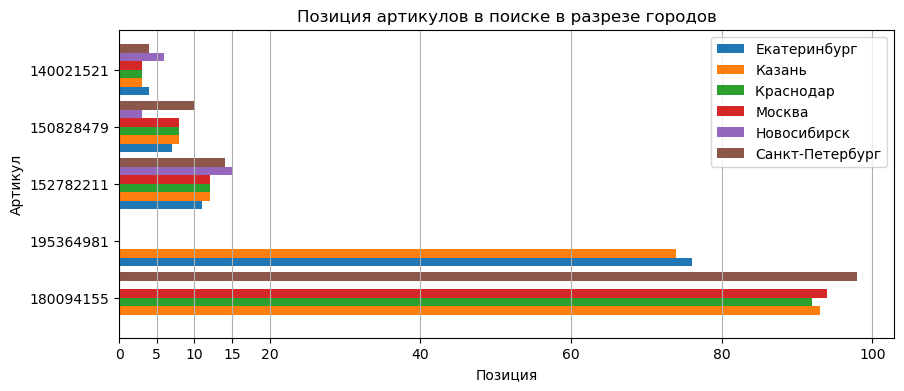

In [9]:
# Пострим линейную гстограмму по позициям артикулов в поиске в разрезе городов
table_city.sort_values('Казань', ascending=False).plot(kind='barh',
                  x='id',
                  y=table_city.columns[1:].tolist(),
                  figsize=(10,4),
                  legend=True,
                  width=0.9
)
plt.title('Позиция артикулов в поиске в разрезе городов')
plt.xlabel('Позиция')
plt.ylabel('Артикул')
plt.legend(loc='best')
plt.grid(axis='x')
plt.xticks([0,5,10,15,20,40,60,80,100]) 
plt.show()

<div style="border: 2px solid #ccc; padding: 10px; border-radius: 5px;">  Из гистограммы, представленной выше, можно увидеть, как меняется позиция в поиске для покупателя, если запрос делается из определенного города. Также в целом видно, какие из артикулов бренда находится выше или ниже в поисковой выдаче. Подробнее можно изучить в сводной таблице позиций по городам, представленной выше.

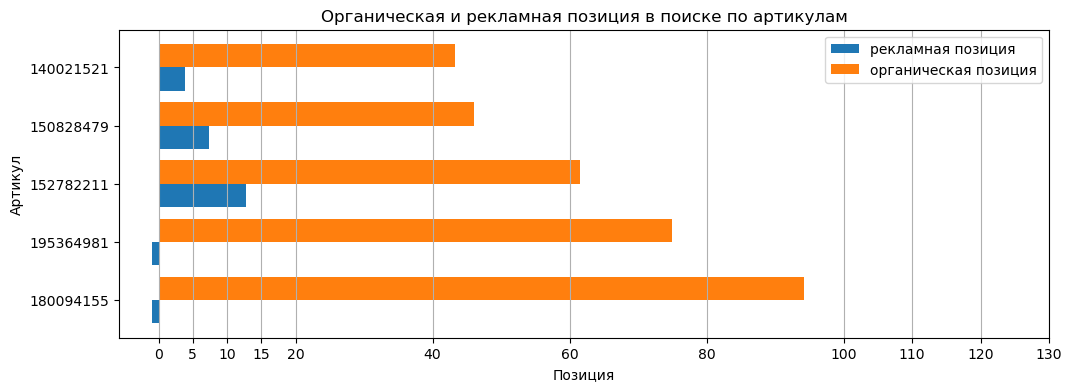

In [10]:
# Пострим линейную гстограмму по органическим и рекламным позициям в поиске по артикулам
table_promo.sort_values('position_org', ascending=False).plot(kind='barh',
                  x='id',
                  y=table_promo.columns[1:].tolist(),
                  figsize=(12,4),
                  legend=True,
                  width=0.8
)
plt.title('Органическая и рекламная позиция в поиске по артикулам')
plt.xlabel('Позиция')
plt.ylabel('Артикул')
plt.legend(['рекламная позиция','органическая позиция'], loc='best')
plt.grid(axis='x')
plt.xticks([0,5,10,15,20,40,60,80,100,110,120,130]) 
plt.show()

<div style="border: 2px solid #ccc; padding: 10px; border-radius: 5px;"> Из гистограммы, представленной выше, можно увидеть разницу между органической и рекламной позициями в выдаче. Также видно, какие из артикулов бренда показываются в рекламе, а какие нет, и, если артикул в рекламе, на какое место он упадет, если выпадет из рекламы. Подробнее можно изучить в 'Сводная таблица позиций в поиске в зависимости от наличия рекламы', которая представлена выше.

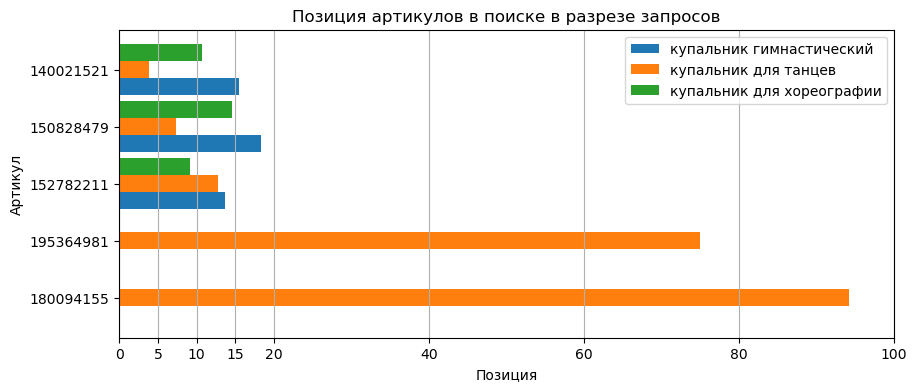

In [11]:
# Пострим линейную гстограмму позиций артикулов в поиске в разрезе запросов
table_query.sort_values('купальник для танцев', ascending=False).plot(kind='barh',
                  x='id',
                  y=table_query.columns[1:].tolist(),
                  figsize=(10,4),
                  legend=True,
                  width=0.9
)
plt.title('Позиция артикулов в поиске в разрезе запросов')
plt.xlabel('Позиция')
plt.ylabel('Артикул')
plt.legend(loc='best')
plt.grid(axis='x')
plt.xticks([0,5,10,15,20,40,60,80,100]) 
plt.show()

<div style="border: 2px solid #ccc; padding: 10px; border-radius: 5px;"> Из гистограммы, представленной выше, можно увидеть, как меняется позиция в поиске для каждого артикула бренда в зависимости от запроса, введенного покупателем в поисковой строке ВБ. Какой-нибудь артикул может не показываться по определенному запросу, и над этим нужно работать менеджеру путем проработки seo и с помощью других инструментов продвижения. Подробнее цифры можно изучить в 'Сводная таблица позиций в поиске в зависимости от запроса', которая представлена выше.

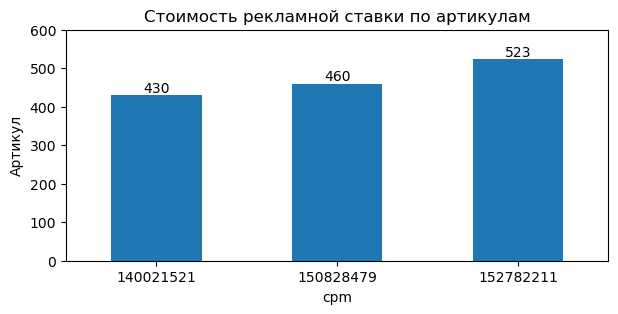

In [12]:
# Пострим линейную гстограмму по стоимости рекламной ставки
ax=table_cpm.plot(kind='bar',
                  x='id',
                  y='cpm',
                  figsize=(7,3),
                  legend=False,
                  rot=0
)
plt.title('Стоимость рекламной ставки по артикулам')
plt.xlabel('cpm')
plt.ylabel('Артикул')
plt.bar_label(ax.containers[0]) 
plt.yticks([0,100,200,300,400,500,600]) 
plt.show()

<div style="border: 2px solid #ccc; padding: 10px; border-radius: 5px;"> Гистограмма, представленная выше, отражает cpm (стоимость рекламной ставки) на вб для каждого артикула на текущий момент времени запуска блокнота.